In [1]:
import pycrfsuite

In [2]:
from collections import Counter
import numpy as np
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [5]:
from _chain import Chain, f_phi, f_psi
from _chain_torch import Chain as ChainTorch
from _loss import HingeLoss
from _data_utils import ChainDataset, count_parameters

from _chain_bp_loss import belief_propagation_cross_entropy_loss  # remove wheb ready

In [6]:
import progressbar

### Define Binary HMM 

In [7]:
phi = f_phi(b=[-0.8, 1])
psi = f_psi(j=2.5)

In [8]:
T = 50 # chain length

In [9]:
chain = Chain(length=T, phi=phi, psi=psi, possible_values=[0, 1])

### Create Random Trainset

In [86]:
possible_values = [0, 1]

In [87]:
N = 1000

In [88]:
%%time 

X_dataset = []
y_dataset= []

for i in range(N):
    x = np.random.rand(T)
    x_binary = 1 * (x > 0.5)
    
    chain.update_observed(x_binary)
    y = chain.get_max_apostriori_beliefs()

    X_dataset.append(x_binary)
    y_dataset.append(y)

CPU times: user 5.88 s, sys: 25.9 ms, total: 5.9 s
Wall time: 5.91 s


In [89]:
# turn to numpy arrays
X_dataset = np.array([np.array(xi) for xi in X_dataset])
y_dataset = np.array([np.array(yi) for yi in y_dataset])

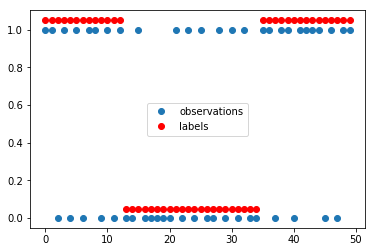

In [90]:
i = np.random.randint(1000)
plot(X_dataset[i], 'o')
plot(y_dataset[i] + 0.05, 'ro')
legend(['observations', 'labels'])

### Train CRF

In [91]:
def extract_features(x):
    features = [
        'x.current=' + str(x)
    ]
    return features

In [92]:
def extract_labels(y):
    return str(y)

#### Preprocess Dataset

In [93]:
X = []
y = []

for xseq, yseq in zip(X_dataset, y_dataset):
    X_features = [extract_features(x_i) for x_i in xseq]
    y_labels = [extract_labels(y_i) for y_i in yseq]
    
    X.append(X_features)
    y.append(y_labels)

#### Train-Test split 

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Train 

In [95]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [96]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0,
    c2=0,  # regulate this up to 1 if needed
    max_iterations=5000,
    all_possible_transitions=True,
    all_possible_states=True
)
crf.fit(X_train, y_train)

CPU times: user 215 ms, sys: 3.43 ms, total: 219 ms
Wall time: 217 ms


In [97]:
y_pred = crf.predict(X_test)

In [98]:
labels = list(crf.classes_)
labels

['0', '1']

In [99]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000      4218
           1      1.000     1.000     1.000      5782

   micro avg      1.000     1.000     1.000     10000
   macro avg      1.000     1.000     1.000     10000
weighted avg      1.000     1.000     1.000     10000



In [100]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

Transitions:
1      -> 1       316.777794
0      -> 0       298.725545
1      -> 0       -306.779830
0      -> 1       -308.723509


In [101]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("States:")
print_state_features(Counter(crf.state_features_).most_common(30))

States:
232.976842 1        x.current=1
203.618869 0        x.current=0
-203.618869 1        x.current=0
-232.976842 0        x.current=1


###  Training MPNN based model

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2)

#### Define 

In [115]:
n_epochs = 100
batch_size = 64 # len(X_train) # 256

In [116]:
trainset = ChainDataset(X_train, y_train)
testset = ChainDataset(X_test, y_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True, num_workers=2)

In [117]:
j = Variable(torch.tensor([1.5]), requires_grad=True)
b = Variable(torch.tensor([-.5, 1.]), requires_grad=True)

In [118]:
init_lr = 0.1

In [119]:
optimizer = optim.Adam([j, b], lr=init_lr)

In [120]:
hinge_loss = HingeLoss(margin=0.2)

In [121]:
model = ChainTorch(length=T)

#### Train

In [122]:
def decay_lr(optimizer, epoch):
    lr = init_lr * (0.5 ** (epoch // 80))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [123]:
learning_curve = []

for epoch in range(1, n_epochs + 1):
    
    for batch in trainloader:
        X_batch, y_batch = Variable(batch['X'], requires_grad=False), Variable(batch['y'], requires_grad=False)
        
        print('J: {},  b0: {}, b1: {}'.format(j[0], b[0], b[1]))
        
        optimizer.zero_grad()
        beliefs = model(j, b, X_batch)
        loss = hinge_loss(beliefs, y_batch)
        loss.backward()
        
        #b.grad.data[1].fill_(0)  # take b[1] as constant
        print('JGrad: {},  bGrad: {}'.format(j.grad.data, b.grad.data))
    
        optimizer.step()
     
    decay_lr(optimizer, epoch) 
    
    # evaluation
    if epoch % 1 == 0:
        valid = next(iter(validloader))
        X_valid, y_valid = Variable(valid['X']), Variable(valid['y']) 
        with torch.no_grad():
            beliefs_valid = model(j, b, X_valid)
            loss_valid = hinge_loss(beliefs_valid, y_valid)

        print('>>>\t epoch {}:: loss = {}, validation loss = {}'. format(epoch, loss, loss_valid))
        learning_curve.append({
            'epoch': epoch + 1,
            'loss': loss,
            'loss_valid': loss_valid,
            'b': [b.data.clone()[0], b.data.clone()[1]],
            'j': j.data.clone()[0],
            'b_grad': [b.grad.data.clone()[0], b.grad.data.clone()[1]],
            'j_grad': j.grad.data.clone()[0]
        })
        

J: 1.5,  b0: -0.5, b1: 1.0
JGrad: tensor([-0.4982]),  bGrad: tensor([5.7505, 2.8125])
J: 1.5999999046325684,  b0: -0.5999999642372131, b1: 0.9000000357627869
JGrad: tensor([-1.3927]),  bGrad: tensor([2.3553, 2.1628])
J: 1.6926288604736328,  b0: -0.6902185678482056, b1: 0.801517128944397
JGrad: tensor([-1.8558]),  bGrad: tensor([-2.8567, -1.1779])
J: 1.7872079610824585,  b0: -0.7268701791763306, b1: 0.749415934085846
JGrad: tensor([-0.5595]),  bGrad: tensor([-6.4184, -7.6943])
J: 1.8759561777114868,  b0: -0.7089552879333496, b1: 0.783065676689148
JGrad: tensor([-0.7949]),  bGrad: tensor([-6.2253, -6.1950])
J: 1.9641926288604736,  b0: -0.6661532521247864, b1: 0.8381059169769287
JGrad: tensor([-1.2086]),  bGrad: tensor([1.2709, 0.7545])
J: 2.0552518367767334,  b0: -0.6353617906570435, b1: 0.881698727607727
JGrad: tensor([-0.8400]),  bGrad: tensor([3.2288, 2.1056])
J: 2.1458959579467773,  b0: -0.6234073042869568, b1: 0.9091455936431885
JGrad: tensor([-0.2825]),  bGrad: tensor([6.3074, 3.36

JGrad: tensor([0.1023]),  bGrad: tensor([1.7957, 0.5518])
J: 4.502917766571045,  b0: -1.3101361989974976, b1: 1.7124183177947998
JGrad: tensor([0.2590]),  bGrad: tensor([3.1324, 1.1437])
J: 4.5197882652282715,  b0: -1.3265656232833862, b1: 1.7189198732376099
JGrad: tensor([0.1367]),  bGrad: tensor([3.2135, 1.4280])
J: 4.532197952270508,  b0: -1.3513963222503662, b1: 1.7188200950622559
JGrad: tensor([-0.1407]),  bGrad: tensor([0.9647, 0.5508])
>>>	 epoch 5:: loss = 0.8491638898849487, validation loss = 0.939270555973053
J: 4.546440124511719,  b0: -1.3769423961639404, b1: 1.7164051532745361
JGrad: tensor([-0.1192]),  bGrad: tensor([ 0.2330, -0.1349])
J: 4.561903476715088,  b0: -1.4008517265319824, b1: 1.714788556098938
JGrad: tensor([-0.3956]),  bGrad: tensor([-1.2562, -0.5641])
J: 4.584341049194336,  b0: -1.4184967279434204, b1: 1.715739369392395
JGrad: tensor([-0.3206]),  bGrad: tensor([-3.4193, -2.6630])
J: 4.6115217208862305,  b0: -1.4234486818313599, b1: 1.727973461151123
JGrad: ten

JGrad: tensor([0.0762]),  bGrad: tensor([ 0.2267, -0.4170])
J: 5.885254383087158,  b0: -1.7422677278518677, b1: 2.2181408405303955
JGrad: tensor([0.2069]),  bGrad: tensor([3.2347, 1.6500])
J: 5.896858215332031,  b0: -1.7538750171661377, b1: 2.2231338024139404
JGrad: tensor([0.0647]),  bGrad: tensor([1.5793, 0.6858])
J: 5.905574321746826,  b0: -1.7704459428787231, b1: 2.224010467529297
JGrad: tensor([-0.0472]),  bGrad: tensor([ 0.0846, -0.1078])
J: 5.914748191833496,  b0: -1.7857515811920166, b1: 2.2253763675689697
JGrad: tensor([0.0656]),  bGrad: tensor([-0.0544, -0.5132])
J: 5.921228885650635,  b0: -1.7993732690811157, b1: 2.2293519973754883
JGrad: tensor([0.2264]),  bGrad: tensor([ 0.3254, -0.6783])
J: 5.920814037322998,  b0: -1.8129554986953735, b1: 2.2365798950195312
JGrad: tensor([-0.1727]),  bGrad: tensor([-1.5141, -1.1619])
J: 5.925230026245117,  b0: -1.8192781209945679, b1: 2.249347686767578
JGrad: tensor([-0.1067]),  bGrad: tensor([-0.3305, -0.3392])
J: 5.932190895080566,  b0:

J: 6.723440647125244,  b0: -2.0588200092315674, b1: 2.573986291885376
JGrad: tensor([-0.0096]),  bGrad: tensor([0.9237, 0.5224])
J: 6.722034931182861,  b0: -2.0834403038024902, b1: 2.5666825771331787
JGrad: tensor([-0.1537]),  bGrad: tensor([-0.1344,  0.0496])
J: 6.725757122039795,  b0: -2.105048656463623, b1: 2.5597779750823975
JGrad: tensor([-0.1000]),  bGrad: tensor([-0.9575, -0.8059])
J: 6.732369899749756,  b0: -2.1201443672180176, b1: 2.5586307048797607
JGrad: tensor([-0.3569]),  bGrad: tensor([-1.9740, -0.8814])
J: 6.749921798706055,  b0: -2.124664783477783, b1: 2.563164234161377
JGrad: tensor([-0.3615]),  bGrad: tensor([-0.7542,  0.0397])
J: 6.777442455291748,  b0: -2.1252682209014893, b1: 2.567005157470703
JGrad: tensor([-0.3904]),  bGrad: tensor([-2.0658, -0.9846])
J: 6.814825534820557,  b0: -2.1162893772125244, b1: 2.5767176151275635
JGrad: tensor([-0.0371]),  bGrad: tensor([-0.2807, -0.3503])
J: 6.849774360656738,  b0: -2.1068880558013916, b1: 2.587712526321411
JGrad: tensor

JGrad: tensor([0.2279]),  bGrad: tensor([1.0552, 0.0270])
J: 7.717237949371338,  b0: -2.2971670627593994, b1: 2.8989498615264893
JGrad: tensor([0.1733]),  bGrad: tensor([1.3153, 0.3502])
J: 7.706139087677002,  b0: -2.312638759613037, b1: 2.9043655395507812
JGrad: tensor([-0.0881]),  bGrad: tensor([1.3688, 1.0761])
J: 7.699322700500488,  b0: -2.333545684814453, b1: 2.9016599655151367
JGrad: tensor([-0.0359]),  bGrad: tensor([-0.5672, -0.6434])
J: 7.694479465484619,  b0: -2.349508762359619, b1: 2.9037632942199707
JGrad: tensor([-0.0296]),  bGrad: tensor([1.6183, 1.1345])
>>>	 epoch 19:: loss = 0.281697154045105, validation loss = 0.46097174286842346
J: 7.691187858581543,  b0: -2.372145414352417, b1: 2.8976409435272217
JGrad: tensor([-0.2259]),  bGrad: tensor([-1.6973, -1.0108])
J: 7.696455001831055,  b0: -2.3838629722595215, b1: 2.899275779724121
JGrad: tensor([-0.0734]),  bGrad: tensor([-1.0344, -0.8709])
J: 7.70388650894165,  b0: -2.3891348838806152, b1: 2.90691876411438
JGrad: tensor(

JGrad: tensor([-0.0808]),  bGrad: tensor([-1.1791, -0.9572])
J: 8.514744758605957,  b0: -2.5723562240600586, b1: 3.1942553520202637
JGrad: tensor([-0.1151]),  bGrad: tensor([-0.0757,  0.0262])
J: 8.530076026916504,  b0: -2.5650763511657715, b1: 3.211215019226074
JGrad: tensor([-0.0649]),  bGrad: tensor([-0.0316, -0.0977])
J: 8.546503067016602,  b0: -2.558335542678833, b1: 3.227259635925293
JGrad: tensor([0.1158]),  bGrad: tensor([ 0.0732, -0.4075])
J: 8.556657791137695,  b0: -2.5526673793792725, b1: 3.2448666095733643
JGrad: tensor([0.0671]),  bGrad: tensor([0.6005, 0.1819])
J: 8.5631103515625,  b0: -2.5509252548217773, b1: 3.2593371868133545
JGrad: tensor([0.2197]),  bGrad: tensor([2.0430, 0.9035])
J: 8.560070991516113,  b0: -2.560809373855591, b1: 3.2653865814208984
JGrad: tensor([0.4424]),  bGrad: tensor([3.0666, 1.0898])
J: 8.539603233337402,  b0: -2.5867981910705566, b1: 3.262402296066284
JGrad: tensor([-0.2264]),  bGrad: tensor([-0.0267,  0.3956])
J: 8.530259132385254,  b0: -2.61

J: 9.209370613098145,  b0: -2.8205533027648926, b1: 3.495701789855957
JGrad: tensor([0.0232]),  bGrad: tensor([0.5717, 0.1518])
J: 9.224807739257812,  b0: -2.8233513832092285, b1: 3.5008366107940674
JGrad: tensor([-0.0323]),  bGrad: tensor([-0.3734, -0.3950])
J: 9.240091323852539,  b0: -2.8236989974975586, b1: 3.508668899536133
JGrad: tensor([-0.0363]),  bGrad: tensor([0.3835, 0.2351])
J: 9.25540828704834,  b0: -2.82624888420105, b1: 3.5138189792633057
JGrad: tensor([0.0264]),  bGrad: tensor([-0.2539, -0.4576])
J: 9.268095016479492,  b0: -2.827064275741577, b1: 3.522183418273926
JGrad: tensor([-0.1140]),  bGrad: tensor([0.3787, 0.3691])
J: 9.284369468688965,  b0: -2.83001446723938, b1: 3.526715040206909
JGrad: tensor([-0.0291]),  bGrad: tensor([0.5235, 0.2627])
J: 9.30027961730957,  b0: -2.835740804672241, b1: 3.528655529022217
JGrad: tensor([-0.0570]),  bGrad: tensor([ 0.0566, -0.0044])
J: 9.317047119140625,  b0: -2.8412346839904785, b1: 3.5304410457611084
JGrad: tensor([-0.1725]),  b

JGrad: tensor([0.1016]),  bGrad: tensor([1.4594, 0.7174])
J: 9.957986831665039,  b0: -3.059131145477295, b1: 3.8112473487854004
JGrad: tensor([-0.0635]),  bGrad: tensor([0.5692, 0.4390])
J: 9.96802043914795,  b0: -3.081503391265869, b1: 3.7964999675750732
JGrad: tensor([-0.2173]),  bGrad: tensor([-1.3292, -0.6604])
J: 9.986742973327637,  b0: -3.0934557914733887, b1: 3.788891315460205
JGrad: tensor([-0.2452]),  bGrad: tensor([-1.7948, -0.9240])
>>>	 epoch 33:: loss = 0.2675135135650635, validation loss = 0.3077027499675751
J: 10.014524459838867,  b0: -3.093151569366455, b1: 3.7899866104125977
JGrad: tensor([-0.1989]),  bGrad: tensor([-1.3431, -0.7185])
J: 10.048408508300781,  b0: -3.0845985412597656, b1: 3.7971584796905518
JGrad: tensor([0.0325]),  bGrad: tensor([0.6476, 0.2873])
J: 10.077496528625488,  b0: -3.080887794494629, b1: 3.80114483833313
JGrad: tensor([-0.1923]),  bGrad: tensor([-1.9166, -1.2083])
J: 10.112279891967773,  b0: -3.0657286643981934, b1: 3.8151464462280273
JGrad: t

JGrad: tensor([-0.0277]),  bGrad: tensor([-1.6484, -1.4070])
J: 10.464712142944336,  b0: -3.3390657901763916, b1: 4.036209583282471
JGrad: tensor([-0.2984]),  bGrad: tensor([-2.4405, -1.3625])
J: 10.469125747680664,  b0: -3.3306639194488525, b1: 4.055274486541748
JGrad: tensor([-0.1643]),  bGrad: tensor([-0.8371, -0.3913])
J: 10.48071575164795,  b0: -3.3178303241729736, b1: 4.0759053230285645
JGrad: tensor([-0.2543]),  bGrad: tensor([-2.0960, -1.2156])
J: 10.502923011779785,  b0: -3.293120861053467, b1: 4.105195045471191
JGrad: tensor([-0.2697]),  bGrad: tensor([-1.6816, -0.8120])
J: 10.535384178161621,  b0: -3.2603209018707275, b1: 4.138741493225098
JGrad: tensor([-0.0970]),  bGrad: tensor([1.4466, 1.2902])
J: 10.569125175476074,  b0: -3.239884853363037, b1: 4.157535552978516
JGrad: tensor([0.1767]),  bGrad: tensor([1.7425, 0.8712])
J: 10.591314315795898,  b0: -3.2324440479278564, b1: 4.1667656898498535
JGrad: tensor([0.1738]),  bGrad: tensor([1.9803, 1.0728])
J: 10.603229522705078,  

J: 11.1378755569458,  b0: -3.4482579231262207, b1: 4.27540397644043
JGrad: tensor([-0.1148]),  bGrad: tensor([-0.5714, -0.3474])
J: 11.143914222717285,  b0: -3.4605801105499268, b1: 4.2687788009643555
JGrad: tensor([-0.1907]),  bGrad: tensor([-0.8131, -0.2911])
J: 11.158417701721191,  b0: -3.4666812419891357, b1: 4.265359878540039
JGrad: tensor([-0.0025]),  bGrad: tensor([-1.6957, -1.5203])
J: 11.171605110168457,  b0: -3.4617483615875244, b1: 4.275594234466553
JGrad: tensor([0.0187]),  bGrad: tensor([-0.5097, -0.5973])
J: 11.182596206665039,  b0: -3.4541678428649902, b1: 4.290046215057373
JGrad: tensor([-0.1433]),  bGrad: tensor([-0.6704, -0.2918])
J: 11.199329376220703,  b0: -3.443209409713745, b1: 4.30562686920166
JGrad: tensor([0.0854]),  bGrad: tensor([0.5351, 0.1863])
J: 11.210325241088867,  b0: -3.436635971069336, b1: 4.318029403686523
JGrad: tensor([-0.0382]),  bGrad: tensor([0.7315, 0.6225])
J: 11.22205924987793,  b0: -3.4352288246154785, b1: 4.323729991912842
JGrad: tensor([0.

JGrad: tensor([0.0266]),  bGrad: tensor([1.2462, 0.8623])
J: 11.630764961242676,  b0: -3.5401158332824707, b1: 4.489452838897705
JGrad: tensor([0.3763]),  bGrad: tensor([2.0569, 0.5947])
J: 11.621200561523438,  b0: -3.5544254779815674, b1: 4.486689567565918
JGrad: tensor([0.1607]),  bGrad: tensor([2.6003, 1.5723])
J: 11.604686737060547,  b0: -3.5834195613861084, b1: 4.470271587371826
JGrad: tensor([-0.0262]),  bGrad: tensor([0.3504, 0.3402])
J: 11.591096878051758,  b0: -3.6117186546325684, b1: 4.452462673187256
JGrad: tensor([0.0067]),  bGrad: tensor([-0.1332, -0.2707])
>>>	 epoch 47:: loss = 0.13198940455913544, validation loss = 0.2596363127231598
J: 11.578524589538574,  b0: -3.6363868713378906, b1: 4.438821792602539
JGrad: tensor([-0.1726]),  bGrad: tensor([-1.1627, -0.6517])
J: 11.575716972351074,  b0: -3.651365041732788, b1: 4.432326793670654
JGrad: tensor([-0.1049]),  bGrad: tensor([-1.3875, -0.9947])
J: 11.578363418579102,  b0: -3.656212568283081, b1: 4.43532133102417
JGrad: ten

JGrad: tensor([-0.0191]),  bGrad: tensor([-0.7339, -0.5849])
J: 11.98960018157959,  b0: -3.709395408630371, b1: 4.601747989654541
JGrad: tensor([0.1620]),  bGrad: tensor([ 0.3232, -0.2018])
J: 11.990168571472168,  b0: -3.7163665294647217, b1: 4.5984721183776855
JGrad: tensor([-0.1329]),  bGrad: tensor([-0.4956, -0.1355])
J: 11.997431755065918,  b0: -3.719501256942749, b1: 4.596756458282471
JGrad: tensor([-0.1143]),  bGrad: tensor([-1.2349, -0.7982])
J: 12.009783744812012,  b0: -3.714484214782715, b1: 4.6024909019470215
JGrad: tensor([0.2863]),  bGrad: tensor([-0.1499, -0.9156])
J: 12.00634479522705,  b0: -3.7090113162994385, b1: 4.616006374359131
JGrad: tensor([0.1416]),  bGrad: tensor([-0.4521, -0.7846])
J: 11.996052742004395,  b0: -3.7012057304382324, b1: 4.6353373527526855
JGrad: tensor([0.0163]),  bGrad: tensor([0.1727, 0.0713])
J: 11.985950469970703,  b0: -3.6952733993530273, b1: 4.652101039886475
JGrad: tensor([0.0018]),  bGrad: tensor([0.9369, 0.6950])
J: 11.976757049560547,  b0

JGrad: tensor([-0.1029]),  bGrad: tensor([1.8763, 1.7147])
>>>	 epoch 56:: loss = 0.33618149161338806, validation loss = 0.1792566329240799
J: 12.244538307189941,  b0: -3.7890172004699707, b1: 4.7177510261535645
JGrad: tensor([0.1022]),  bGrad: tensor([1.0611, 0.5484])
J: 12.251686096191406,  b0: -3.8109371662139893, b1: 4.694506645202637
JGrad: tensor([0.0465]),  bGrad: tensor([0.2731, 0.0271])
J: 12.25568675994873,  b0: -3.832486867904663, b1: 4.673309803009033
JGrad: tensor([-0.1087]),  bGrad: tensor([-1.4429, -1.0076])
J: 12.264986991882324,  b0: -3.842355489730835, b1: 4.6637797355651855
JGrad: tensor([-0.0922]),  bGrad: tensor([-1.6950, -1.2509])
J: 12.278197288513184,  b0: -3.840045213699341, b1: 4.667055130004883
JGrad: tensor([-0.1623]),  bGrad: tensor([-0.9886, -0.5161])
J: 12.298604965209961,  b0: -3.831434726715088, b1: 4.674898147583008
JGrad: tensor([-0.0353]),  bGrad: tensor([-1.0612, -0.9069])
J: 12.318842887878418,  b0: -3.8166680335998535, b1: 4.690557956695557
JGrad:

JGrad: tensor([-0.1164]),  bGrad: tensor([0.1271, 0.3302])
J: 12.486655235290527,  b0: -3.8907766342163086, b1: 4.814741134643555
JGrad: tensor([-0.1089]),  bGrad: tensor([-1.8001, -1.2761])
J: 12.494983673095703,  b0: -3.882295608520508, b1: 4.825955390930176
JGrad: tensor([0.1777]),  bGrad: tensor([ 0.0553, -0.4700])
J: 12.492874145507812,  b0: -3.875035047531128, b1: 4.840685844421387
JGrad: tensor([0.0951]),  bGrad: tensor([1.4892, 0.9268])
J: 12.48582935333252,  b0: -3.878704786300659, b1: 4.844812393188477
JGrad: tensor([0.1610]),  bGrad: tensor([ 0.3823, -0.1252])
J: 12.470775604248047,  b0: -3.884631872177124, b1: 4.849764347076416
JGrad: tensor([-0.1403]),  bGrad: tensor([1.0316, 1.1292])
>>>	 epoch 61:: loss = 0.20559990406036377, validation loss = 0.1817384660243988
J: 12.464818954467773,  b0: -3.8970465660095215, b1: 4.843084335327148
JGrad: tensor([0.0294]),  bGrad: tensor([0.6100, 0.3288])
J: 12.457860946655273,  b0: -3.9124162197113037, b1: 4.833822250366211
JGrad: tenso

JGrad: tensor([0.2345]),  bGrad: tensor([ 0.0592, -0.6154])
J: 12.829360008239746,  b0: -3.9654901027679443, b1: 4.935545921325684
JGrad: tensor([0.0622]),  bGrad: tensor([0.3587, 0.1017])
J: 12.83555793762207,  b0: -3.9558913707733154, b1: 4.95094108581543
JGrad: tensor([0.1171]),  bGrad: tensor([1.1938, 0.6330])
J: 12.834708213806152,  b0: -3.955620765686035, b1: 4.958375453948975
JGrad: tensor([0.0388]),  bGrad: tensor([0.3641, 0.1745])
J: 12.831809043884277,  b0: -3.9579319953918457, b1: 4.9632978439331055
JGrad: tensor([0.0803]),  bGrad: tensor([0.6864, 0.3266])
J: 12.824779510498047,  b0: -3.9648332595825195, b1: 4.964409351348877
JGrad: tensor([0.1159]),  bGrad: tensor([0.7793, 0.3050])
J: 12.812068939208984,  b0: -3.9765236377716064, b1: 4.962305068969727
JGrad: tensor([0.1111]),  bGrad: tensor([0.6704, 0.2213])
J: 12.794507026672363,  b0: -3.991765260696411, b1: 4.958154678344727
JGrad: tensor([-0.0371]),  bGrad: tensor([0.4704, 0.4079])
J: 12.780731201171875,  b0: -4.00880336

JGrad: tensor([-0.1115]),  bGrad: tensor([-0.4676, -0.1406])
J: 13.05232048034668,  b0: -4.134466648101807, b1: 4.963985443115234
JGrad: tensor([-0.1275]),  bGrad: tensor([-1.7720, -1.2294])
>>>	 epoch 70:: loss = 0.22305937111377716, validation loss = 0.29843732714653015
J: 13.053897857666016,  b0: -4.14101505279541, b1: 4.961389064788818
JGrad: tensor([-0.2496]),  bGrad: tensor([-2.4364, -1.4605])
J: 13.069276809692383,  b0: -4.129420280456543, b1: 4.974390506744385
JGrad: tensor([-0.3867]),  bGrad: tensor([-2.1741, -0.9067])
J: 13.104644775390625,  b0: -4.103419780731201, b1: 4.995614051818848
JGrad: tensor([-0.0352]),  bGrad: tensor([-1.1700, -0.9218])
J: 13.13846492767334,  b0: -4.071628570556641, b1: 5.024396896362305
JGrad: tensor([0.1387]),  bGrad: tensor([0.6082, 0.0902])
J: 13.161166191101074,  b0: -4.047358512878418, b1: 5.049374580383301
JGrad: tensor([0.0700]),  bGrad: tensor([-0.5881, -0.6796])
J: 13.177701950073242,  b0: -4.021279811859131, b1: 5.079010009765625
JGrad: t

JGrad: tensor([-0.1155]),  bGrad: tensor([0.9785, 1.0144])
J: 13.331475257873535,  b0: -4.174179553985596, b1: 5.187685489654541
JGrad: tensor([-0.2121]),  bGrad: tensor([-0.8138, -0.1779])
J: 13.358060836791992,  b0: -4.166999816894531, b1: 5.189772605895996
JGrad: tensor([0.0545]),  bGrad: tensor([0.4418, 0.1914])
J: 13.37893009185791,  b0: -4.163761138916016, b1: 5.18959379196167
JGrad: tensor([0.1100]),  bGrad: tensor([1.8264, 1.1490])
J: 13.391518592834473,  b0: -4.174182891845703, b1: 5.177082538604736
JGrad: tensor([0.0587]),  bGrad: tensor([0.2474, 0.0067])
J: 13.399543762207031,  b0: -4.185377597808838, b1: 5.165740966796875
JGrad: tensor([-0.0113]),  bGrad: tensor([-0.3102, -0.2627])
>>>	 epoch 75:: loss = 0.16704992949962616, validation loss = 0.17432008683681488
J: 13.407407760620117,  b0: -4.193192481994629, b1: 5.158353805541992
JGrad: tensor([-0.0715]),  bGrad: tensor([-1.1727, -0.8436])
J: 13.418533325195312,  b0: -4.191650867462158, b1: 5.160787105560303
JGrad: tensor(

JGrad: tensor([-0.2520]),  bGrad: tensor([-1.7243, -0.8444])
J: 13.577388763427734,  b0: -4.255281448364258, b1: 5.311437606811523
JGrad: tensor([-0.1202]),  bGrad: tensor([0.3993, 0.5791])
J: 13.608211517333984,  b0: -4.236711502075195, b1: 5.324702739715576
JGrad: tensor([0.0736]),  bGrad: tensor([0.9262, 0.5172])
J: 13.631730079650879,  b0: -4.22692346572876, b1: 5.3309197425842285
JGrad: tensor([0.0583]),  bGrad: tensor([1.2210, 0.7998])
J: 13.649554252624512,  b0: -4.2272515296936035, b1: 5.327656269073486
JGrad: tensor([-0.0602]),  bGrad: tensor([0.1162, 0.2172])
J: 13.66908073425293,  b0: -4.22841739654541, b1: 5.3223090171813965
JGrad: tensor([0.1304]),  bGrad: tensor([1.4444, 0.7803])
J: 13.679137229919434,  b0: -4.240283966064453, b1: 5.308844566345215
JGrad: tensor([0.0475]),  bGrad: tensor([-0.0121, -0.1613])
J: 13.68545150756836,  b0: -4.250881671905518, b1: 5.298506736755371
JGrad: tensor([0.1615]),  bGrad: tensor([1.2297, 0.5513])
J: 13.68181037902832,  b0: -4.2696385383

JGrad: tensor([0.0496]),  bGrad: tensor([-2.2991, -2.0470])
>>>	 epoch 84:: loss = 0.21311965584754944, validation loss = 0.15868261456489563
J: 13.832858085632324,  b0: -4.295812606811523, b1: 5.337481498718262
JGrad: tensor([0.0687]),  bGrad: tensor([-0.2374, -0.3998])
J: 13.840408325195312,  b0: -4.281907081604004, b1: 5.35336446762085
JGrad: tensor([0.0872]),  bGrad: tensor([0.8537, 0.4309])
J: 13.84466552734375,  b0: -4.2726521492004395, b1: 5.365220069885254
JGrad: tensor([0.1329]),  bGrad: tensor([0.4771, 0.0220])
J: 13.844619750976562,  b0: -4.266143798828125, b1: 5.3757734298706055
JGrad: tensor([0.0504]),  bGrad: tensor([-0.0387, -0.1889])
J: 13.843108177185059,  b0: -4.260133266448975, b1: 5.3863525390625
JGrad: tensor([-0.0090]),  bGrad: tensor([0.8568, 0.6816])
J: 13.842009544372559,  b0: -4.258005142211914, b1: 5.391999244689941
JGrad: tensor([0.0668]),  bGrad: tensor([1.2757, 0.8244])
J: 13.839065551757812,  b0: -4.260979175567627, b1: 5.392391681671143
JGrad: tensor([-0

JGrad: tensor([-0.0983]),  bGrad: tensor([-0.2664, -0.0291])
J: 13.914007186889648,  b0: -4.353469371795654, b1: 5.399169445037842
JGrad: tensor([0.1075]),  bGrad: tensor([0.7719, 0.3235])
J: 13.916969299316406,  b0: -4.3555073738098145, b1: 5.39794397354126
JGrad: tensor([0.1448]),  bGrad: tensor([1.5834, 0.8649])
J: 13.915336608886719,  b0: -4.3635454177856445, b1: 5.39180326461792
JGrad: tensor([-0.2456]),  bGrad: tensor([-1.6784, -0.7797])
J: 13.921156883239746,  b0: -4.364202499389648, b1: 5.390817642211914
JGrad: tensor([-0.1262]),  bGrad: tensor([-0.6011, -0.2345])
>>>	 epoch 89:: loss = 0.15116937458515167, validation loss = 0.15314437448978424
J: 13.930144309997559,  b0: -4.362438678741455, b1: 5.391296863555908
JGrad: tensor([-0.2510]),  bGrad: tensor([-1.3130, -0.5022])
J: 13.945670127868652,  b0: -4.355706691741943, b1: 5.394657611846924
JGrad: tensor([0.1497]),  bGrad: tensor([ 0.1235, -0.3294])
J: 13.955205917358398,  b0: -4.350127696990967, b1: 5.399606704711914
JGrad: t

JGrad: tensor([0.0742]),  bGrad: tensor([-0.1534, -0.3519])
J: 14.065376281738281,  b0: -4.4000630378723145, b1: 5.4433112144470215
JGrad: tensor([0.0847]),  bGrad: tensor([ 0.1170, -0.1628])
J: 14.072004318237305,  b0: -4.3986430168151855, b1: 5.4447526931762695
JGrad: tensor([0.0527]),  bGrad: tensor([-0.5599, -0.6483])
J: 14.07638931274414,  b0: -4.3951263427734375, b1: 5.449926853179932
JGrad: tensor([-0.0310]),  bGrad: tensor([0.1265, 0.1592])
J: 14.08127212524414,  b0: -4.392465114593506, b1: 5.453634262084961
JGrad: tensor([0.0347]),  bGrad: tensor([0.2277, 0.0779])
J: 14.084626197814941,  b0: -4.390979290008545, b1: 5.456506729125977
JGrad: tensor([0.1314]),  bGrad: tensor([0.9012, 0.3644])
J: 14.083687782287598,  b0: -4.393249988555908, b1: 5.456909656524658
JGrad: tensor([0.1577]),  bGrad: tensor([1.2696, 0.5890])
J: 14.078089714050293,  b0: -4.400376319885254, b1: 5.453742027282715
JGrad: tensor([-0.0529]),  bGrad: tensor([0.1525, 0.2303])
J: 14.0746431350708,  b0: -4.407405

J: 14.225187301635742,  b0: -4.428073406219482, b1: 5.498688697814941
JGrad: tensor([0.1323]),  bGrad: tensor([1.4704, 0.8253])
J: 14.23808765411377,  b0: -4.421154975891113, b1: 5.503580570220947
JGrad: tensor([0.0994]),  bGrad: tensor([ 0.0993, -0.1956])
J: 14.246678352355957,  b0: -4.4153265953063965, b1: 5.509179592132568
JGrad: tensor([0.1152]),  bGrad: tensor([1.1808, 0.6276])
J: 14.250904083251953,  b0: -4.414863109588623, b1: 5.51038932800293
JGrad: tensor([0.0959]),  bGrad: tensor([ 0.0763, -0.2128])
J: 14.251789093017578,  b0: -4.414755344390869, b1: 5.5127787590026855
JGrad: tensor([0.0383]),  bGrad: tensor([0.8620, 0.5812])
J: 14.25141716003418,  b0: -4.418153285980225, b1: 5.511378765106201
JGrad: tensor([0.1790]),  bGrad: tensor([0.7839, 0.1383])
J: 14.245628356933594,  b0: -4.424392223358154, b1: 5.509272575378418
JGrad: tensor([0.1645]),  bGrad: tensor([1.1543, 0.4669])
J: 14.235404968261719,  b0: -4.434690475463867, b1: 5.504519939422607
JGrad: tensor([0.0330]),  bGrad

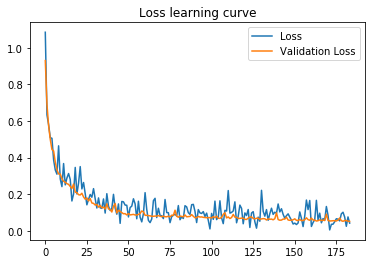

In [451]:
plot([(v['loss'], v['loss_valid']) for v in learning_curve]);
title('Loss learning curve');
legend(['Loss', 'Validation Loss']);

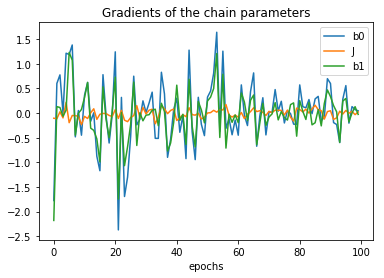

In [443]:
plot([(v['b_grad'][0], v['j_grad'],  v['b_grad'][1]) for v in learning_curve]);
title('Gradients of the chain parameters')
xlabel('epochs')
legend(['b0', 'J', 'b1'])

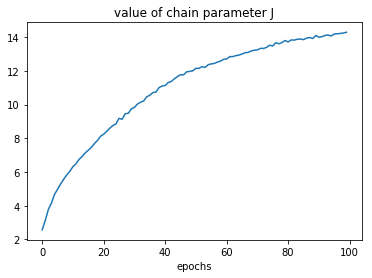

In [444]:
plot([v['j'] for v in learning_curve]);
title('value of chain parameter J');
xlabel('epochs');

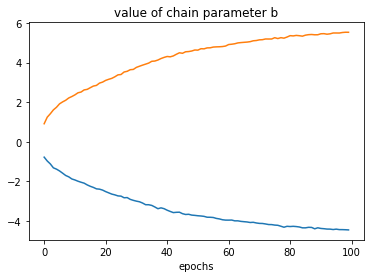

In [445]:
plot([v['b'] for v in learning_curve]);
title('value of chain parameter b');
xlabel('epochs');

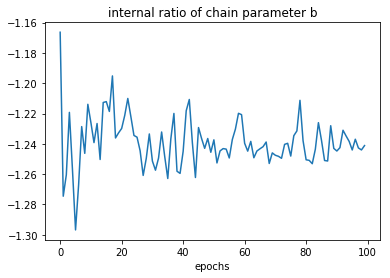

In [446]:
plot([v['b'][1] / v['b'][0] for v in learning_curve]);
title('internal ratio of chain parameter b');
xlabel('epochs');

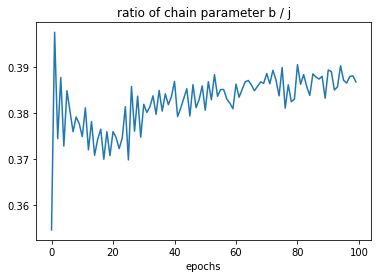

In [447]:
plot([v['b'][1] / v['j'] for v in learning_curve]);
title('ratio of chain parameter b / j');
xlabel('epochs');

### Evaluate 

In [452]:
beliefs_pred = model(j, b, X_test)

y_pred = (beliefs_pred > 0.5)\
    .float()
    .detach()\
    .numpy()

In [453]:
labels = {0 : 0, 1: 1}

predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4052
           1       1.00      1.00      1.00      5948

   micro avg       1.00      1.00      1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



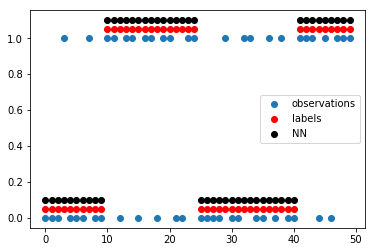

In [454]:
i = np.random.randint(200)
plot(X_test[i], 'o')
plot(y_test[i] + 0.05, 'ro')
plot(y_pred[i] + 0.1, 'ko')
legend(['observations', 'labels', 'NN'])

### Sanity - check that we can reach loss zero

In [363]:
ind = np.random.randint(1000)
j = [2.5] #[1]
b = [-0.8, 1.]
labels = y_dataset[ind]
observations = X_dataset[ind]

In [142]:
labels.shape, observations.shape

((50,), (50,))

In [143]:
# add batch dimension

In [144]:
labels = np.expand_dims(labels, axis=0)
observations = np.expand_dims(observations, axis=0)

In [145]:
# move to tensors

In [146]:
import torch

In [147]:
j = torch.Tensor(j)
b = torch.Tensor(b)
labels = torch.Tensor(labels)
observations = torch.Tensor(observations)

In [148]:
%%time
loss = belief_propagation_cross_entropy_loss(j, b, observations, labels, chain_len=T)
beliefs = belief_propagation_cross_entropy_loss(j, b, observations, labels, chain_len=T, train=False)[-1]

CPU times: user 15 ms, sys: 1.31 ms, total: 16.3 ms
Wall time: 15.2 ms


In [149]:
loss, torch.eq(labels, beliefs.float()), torch.all(torch.eq(labels, beliefs.float()))

(tensor(0.4884),
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1]], dtype=torch.uint8),
 tensor(1, dtype=torch.uint8))

In [150]:
labels

tensor([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [140]:
beliefs

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

###  Plot the loss function

####  target loss

In [109]:
j = [2.5]
b = [-0.8, 1.]

len_ = len(X_train[:10])

j = torch.Tensor(j) 
b = torch.Tensor(b)

observations = torch.Tensor(X_train[:10])
labels = torch.Tensor(y_train[:10])

target_loss = belief_propagation_cross_entropy_loss(j, b, observations, labels, chain_len=T)
beliefs = belief_propagation_cross_entropy_loss(j, b, observations, labels, chain_len=T, train=False)

target_loss, int(torch.all(torch.eq(labels, beliefs.float())))

(tensor(0.4683), 1)

#### Plot loss surface

In [299]:
bar = progressbar.ProgressBar(maxval=3000, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

In [300]:
res = {'b0': [], 'b1': [], 'j': [], 'loss': [], 'zero_one_loss': []}

bar.start()
for i_sample in range(3000):
    bar.update(i_sample + 1)
    j_val = 2.5 + 5 * (np.random.rand() - 0.5)
    b_base = [2 * (np.random.rand() - 0.5) , 1]
  
    j = torch.Tensor([j_val])
    b = torch.Tensor(b_base)
    
    labels = torch.Tensor(y_train[:10])
    observations = torch.Tensor(X_train[:10])
    
    res['b0'].append(b_base[0])
    res['b1'].append(b_base[1])
    res['j'].append(j_val)
    res['loss'].append(float(belief_propagation_cross_entropy_loss(j, b, observations, labels, chain_len=T)))
    
    beliefs = belief_propagation_cross_entropy_loss(j, b, observations, labels, chain_len=T, train=False)
    res['zero_one_loss'].append(int(torch.all(torch.eq(labels, beliefs.float()))))
    
bar.finish()

[========================================================================] 100%


In [301]:
df = pd.DataFrame(res)

In [302]:
df.zero_one_loss.value_counts()

0    2988
1      12
Name: zero_one_loss, dtype: int64

In [303]:
import plotly.graph_objects as go

trace = go.Scatter3d(
        x=df['b0'],
        y=df['j'], 
        z=df['loss'], 
        mode='markers',
        marker=dict(
            size=10,
            color=df['zero_one_loss'],                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8
        ),
)

data = [trace]

scene = go.layout.Scene(
        annotations=[
            dict(
                x=-.8,
                y=2.5,
                z=target_loss,
                text="target",
                textangle=0,
                ax=0,
                ay=-75,
                font=dict(
                    color="red",
                    size=18
                ),
                arrowcolor="red",
                arrowsize=3,
                arrowwidth=1,
                arrowhead=1
        )],
)

fig = go.Figure()
fig.add_trace(trace)
fig.update_layout(scene=scene)
fig.write_html('loss_vs_data_term.html', auto_open=True)